In [15]:
import sys
import os
import numpy as np
import warnings
from tqdm.auto import tqdm
import pickle
import matplotlib.pyplot as plt
import pandas as pd


# Suppress all warnings
warnings.filterwarnings("ignore")

## replace with root project dir
PROJECT_DIR = "/mnt/workspace/__ing/llming/DTC/audio_podcast_qa_assistant"
sys.path.append(PROJECT_DIR)

from utils.utils import (
    initialize_env_variables,
    flatten_list_of_lists,
    sample_from_list,
    read_json_file,
    save_json_file,
    extract_item_by_keys,
    save_to_pickle,
    load_pickle,
    get_json_files_in_dir,
    read_json_file
)

initialize_env_variables()

from utils.questions import (extract_questions,
                             group_questions_by_episode, 
                             openai_process_questions,
                            filter_corrupted_qs,
                            count_question_marks)
from utils.multithread import map_progress
from datasets import load_dataset, Dataset
from utils.ollama import embed_document
from utils.variables import OLLAMA_CLIENT

from transformers import LEDForConditionalGeneration, LEDTokenizer
import torch

from utils.query import (
    elastic_search_text, elastic_search_knn, elastic_search_hybrid_rrf
)
from utils.variables import ES_CLIENT
from utils.query import (
    elastic_search_text, elastic_search_knn, elastic_search_hybrid_rrf
)
from utils.variables import ES_CLIENT
from utils.evaluate import hit_rate, mrr, retrieve_relevance

Initialized environment variables listed in: /mnt/workspace/__ing/llming/DTC/audio_podcast_qa_assistant/.env


# Episode summarization (Skipped)

In [12]:
# chunked_docs_path = os.path.join(
#     PROJECT_DIR,
#     "data/generated_documents/documents.json"
# )
# chunks_dataset = read_json_file(chunked_docs_path)

In [6]:
# # from huggingface_hub import login
# cache_dir = os.path.join(PROJECT_DIR, "hf_cache")

# # login(os.getenv("HF_READING_TOKEN"))

# full_dataset = load_dataset(
#     path='Whispering-GPT/lex-fridman-podcast-transcript-audio', 
#     cache_dir=cache_dir,
#     ignore_verifications=True,
# )['train']

Using the latest cached version of the dataset since Whispering-GPT/lex-fridman-podcast-transcript-audio couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'default' at /mnt/workspace/__ing/llming/DTC/audio_podcast_qa_assistant/hf_cache/Whispering-GPT___lex-fridman-podcast-transcript-audio/default/0.0.0/86c17541f78440e5ff2ef55740a3a503b2716d3a (last modified on Sat Aug 24 03:36:38 2024).


Loading dataset shards:   0%|          | 0/69 [00:00<?, ?it/s]

In [7]:
# try:
#     full_dataset = full_dataset.remove_columns(['audio'])
# except ValueError:
#     pass

In [2]:
# full_dataset[0]["text"]

In [24]:
# full_dataset[0]["text"] == "".join([segment["text"] for segment in full_dataset[0]["segments"]])

True

In [23]:
# def extract_outline(episode):
#     """
#     """
#     outline_started = False
#     outline = []
    
#     for line in episode["description"].split("\n"):
#         if "OUTLINE:" in line:
#             outline_started = True
#             continue
#         if outline_started:
#             if line.strip() == "" or line.startswith("CONNECT:"):
#                 break
#             outline.append(line.strip())
            
#     episode["outline"] = outline
#     return episode

# full_dataset = full_dataset.map(extract_outline, batched=False)

# Generating questions

In [34]:
chunked_docs_path = os.path.join(
    PROJECT_DIR,
    "data/generated_documents/documents.json"
)
full_dataset = read_json_file(chunked_docs_path)

In [3]:
questions = map_progress(
    f=lambda episode:extract_questions(
        episode=episode,
        min_words=15,
        max_words=20
    ),
    seq=full_dataset,
    max_workers=4,
    verbose=False
)

questions = flatten_list_of_lists(questions)

  0%|          | 0/30681 [00:00<?, ?it/s]

In [4]:
### Will perform no sampling

# print("Number of questions before sampling:", len(questions))
# questions = sample_from_list(questions, sample_size=1000, seed=42)
# print("Number of questions after sampling:", len(questions))

In [5]:
# Group questions by episode_id
questions_per_episode = group_questions_by_episode(questions)

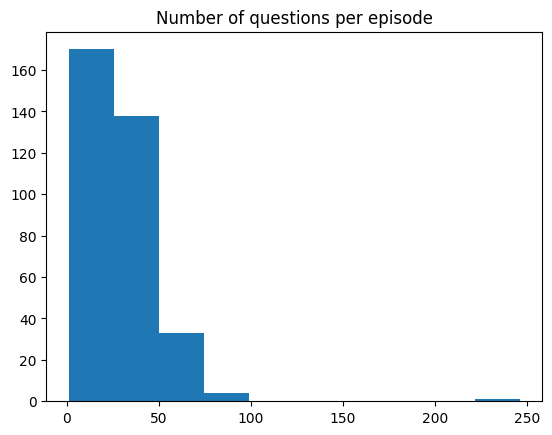

In [6]:
plt.title("Number of questions per episode")
_ = plt.hist([len(ep) for ep in questions_per_episode])

# Extracting Self-sufficient

In [12]:
# exclude documents already processed using a separate function

In [7]:
prompt_template_path = os.path.join(PROJECT_DIR, "prompts/self_sufficient_qs.txt")

self_sufficient_questions = map_progress(
    f=lambda episode_questions:openai_process_questions(
        episode_questions=episode_questions,
        prompt_template_path=prompt_template_path,
        model="gpt-4o-mini",
    ),
    seq=questions_per_episode,
    max_workers=4,
    verbose=False
)

self_sufficient_questions = flatten_list_of_lists(self_sufficient_questions)

  0%|          | 0/346 [00:00<?, ?it/s]

Data successfully saved to /mnt/workspace/__ing/llming/DTC/audio_podcast_qa_assistant/data/generated_questions/episodes/TRdL6ZzWBS0.json
Data successfully saved to /mnt/workspace/__ing/llming/DTC/audio_podcast_qa_assistant/data/generated_questions/episodes/TPXTmVdlyoc.json
Data successfully saved to /mnt/workspace/__ing/llming/DTC/audio_podcast_qa_assistant/data/generated_questions/episodes/-t1_ffaFXao.json
Data successfully saved to /mnt/workspace/__ing/llming/DTC/audio_podcast_qa_assistant/data/generated_questions/episodes/BCdV6BMMpOo.json
Data successfully saved to /mnt/workspace/__ing/llming/DTC/audio_podcast_qa_assistant/data/generated_questions/episodes/Kedt2or9xlo.json
Data successfully saved to /mnt/workspace/__ing/llming/DTC/audio_podcast_qa_assistant/data/generated_questions/episodes/M95m2EFb7IQ.json
Data successfully saved to /mnt/workspace/__ing/llming/DTC/audio_podcast_qa_assistant/data/generated_questions/episodes/R5rNoV1Qy_Q.json
Data successfully saved to /mnt/workspace

In [8]:
self_sufficient_questions_filtered =\
    filter_corrupted_qs(self_sufficient_questions, full_dataset)

In [9]:
print("Number of question marks in original dataset:", count_question_marks(full_dataset))
print("Number of questions extracted from transcriptions using :", len(questions))
print("Number of questions after discarding non-self sufficient using openai:", len(self_sufficient_questions))
print("Number of questions after filteration of corrupted questions:", len(self_sufficient_questions_filtered))

Number of question marks in original dataset: 68112
Number of questions extracted from transcriptions using : 10143
Number of questions after discarding non-self sufficient using openai: 747
Number of questions after filteration of corrupted questions: 455


In [10]:
questions_path = os.path.join(
    PROJECT_DIR,
    "data/generated_questions/",
    "self-sufficient-filtered-questions.json"
)

save_json_file(self_sufficient_questions_filtered, questions_path, replace=True)

Data successfully saved to /mnt/workspace/__ing/llming/DTC/audio_podcast_qa_assistant/data/generated_questions/self-sufficient-filtered-questions.json


# Evaluating Performance on questions without rephrasing

In [4]:
q_path = os.path.join(
    PROJECT_DIR,
    "data/generated_questions/self-sufficient-filtered-questions.json"
)
self_sufficient_questions_filtered = read_json_file(q_path)

In [11]:
for doc in self_sufficient_questions_filtered:
    doc["text"] = doc.pop("question")

In [13]:
vectorized_questions = map_progress(
    f=lambda q: embed_document(OLLAMA_CLIENT, q),
    seq=self_sufficient_questions_filtered,
    max_workers=4,
    verbose=False
)

  0%|          | 0/455 [00:00<?, ?it/s]

In [41]:
pickle_file_path = os.path.join(
    PROJECT_DIR, 
    "data/generated_document_embeddings/vectorized_self_sufficient_questions.pkl"
)

save_to_pickle(vectorized_questions, pickle_file_path)

In [29]:
search_func_list = [
    elastic_search_text,
    elastic_search_knn,
    elastic_search_hybrid_rrf
]
search_func_keys_list = [
    {"query":"text"},
    {"query_vector":"text_vector"},
    {"query":"text", "query_vector":"text_vector"}    
]
performance = []

for i in range(len(search_func_list)):
    relevance = map_progress(
        f=lambda question_dict: retrieve_relevance(
            question_dict=question_dict,
            search_func=search_func_list[i],
            **search_func_keys_list[i]
        ),
        seq=vectorized_questions,
        max_workers=4,
        verbose=False
    )
    
    performance.append(
        {
            "Search": search_func_list[i].__name__,
            "HR": hit_rate(relevance),
            "MRR": mrr(relevance)
        }
    )

  0%|          | 0/455 [00:00<?, ?it/s]

  0%|          | 0/455 [00:00<?, ?it/s]

  0%|          | 0/455 [00:00<?, ?it/s]

In [31]:
pd.DataFrame(performance)

,Search,HR,MRR
0,elastic_search_text,0.008791,0.004835
1,elastic_search_knn,0.013187,0.005568
2,elastic_search_hybrid_rrf,0.010989,0.005934


# Rephrasing self-sufficient questions

In [7]:
prompt_template_path = os.path.join(PROJECT_DIR, "prompts/rephrase_questions.txt")

rephrased_questions = map_progress(
    f=lambda episode_questions:openai_rephrase(
        episode_questions=episode_questions,
        prompt_template_path=prompt_template_path,
        model="gpt-4o-mini",
    ),
    seq=questions_per_episode,
    max_workers=4,
    verbose=False
)

rephrased_questions = flatten_list_of_lists(rephrased_questions)

  0%|          | 0/302 [00:00<?, ?it/s]

In [8]:
print("Number of questions before rephrasing & keeping self-sufficient only:", len(questions))
print("Number of questions after rephrasing & keeping self-sufficient only:", len(rephrased_questions))

Number of questions before rephrasing & keeping self-sufficient only: 1000
Number of questions after rephrasing & keeping self-sufficient only: 344


In [9]:
rephrased_questions_reviewed = []
for i, rephrased_question in enumerate(rephrased_questions):
    try:
        rephrased_question["text"] = rephrased_question.pop("question")
        rephrased_question["episode_id"]; rephrased_question["chunk_id"]
        
        rephrased_questions_reviewed.append(rephrased_question)
    except:
        pass

In [10]:
print("Number of questions before reviewing:", len(rephrased_questions))
print("Number of questions after reviewing:", len(rephrased_questions_reviewed))

Number of questions before reviewing: 344
Number of questions after reviewing: 12


In [44]:
questions_path = os.path.join(
    PROJECT_DIR,
    "data/generated_questions/",
    "questions.json"
)

save_json_file(rephrased_questions_reviewed, questions_path, replace=True)

Data successfully saved to /mnt/workspace/__ing/llming/DTC/audio_podcast_qa_assistant/data/generated_questions/questions.json


# Vectorizing docs

In [45]:
from utils.ollama import embed_document
from utils.variables import OLLAMA_CLIENT

In [31]:
questions_path = os.path.join(
    PROJECT_DIR,
    "data/generated_questions/",
    "questions.json"
)

rephrased_questions = read_json_file(questions_path)

In [32]:
vectorized_questions = map_progress(
    f=lambda q: embed_document(OLLAMA_CLIENT, q),
    seq=rephrased_questions_reviewed,
    max_workers=4,
    verbose=False
)

  0%|          | 0/495 [00:00<?, ?it/s]

1/495 items processed so far...
25/495 items processed so far...
49/495 items processed so far...
73/495 items processed so far...
97/495 items processed so far...
121/495 items processed so far...
145/495 items processed so far...
169/495 items processed so far...
193/495 items processed so far...
217/495 items processed so far...
241/495 items processed so far...
265/495 items processed so far...
289/495 items processed so far...
313/495 items processed so far...
337/495 items processed so far...
361/495 items processed so far...
385/495 items processed so far...
409/495 items processed so far...
433/495 items processed so far...
457/495 items processed so far...
481/495 items processed so far...
495/495 items processed.


In [39]:
pickle_file_path = os.path.join(
    PROJECT_DIR, 
    "data/generated_document_embeddings/vectorized_questions.pkl"
)

save_to_pickle(vectorized_questions, pickle_file_path)

# Assessing Retrieval

In [3]:
pickle_file_path = os.path.join(
    PROJECT_DIR, 
    "data/generated_document_embeddings/vectorized_questions.pkl"
)
vectorized_questions = load_pickle(pickle_file_path)

In [4]:
vectorized_questions[0]["text"]

'What is the key methodology of the clustering that enables its effectiveness?'

In [28]:
performance = []

### Text

In [5]:
def text_retrieval(question_dict):
    ground_truth = (question_dict['episode_id'], question_dict['chunk_id'])
    return [
        (doc['id'], doc['chunk_id']) == ground_truth\
        for doc in elastic_search_text(question_dict["text"])
    ]

In [10]:
text_relevance = map_progress(
    f=text_retrieval,
    seq=vectorized_questions,
    max_workers=4,
    verbose=False
)

  0%|          | 0/495 [00:00<?, ?it/s]

In [29]:
performance.append(
    {
        "Search": "elastic_search_text",
        "HR": hit_rate(text_relevance),
        "MRR": mrr(text_relevance)
    }
)

### Vector

In [17]:
def knn_retrieval(question_dict):
    ground_truth = (question_dict['episode_id'], question_dict['chunk_id'])
    return [
        (doc['id'], doc['chunk_id']) == ground_truth\
        for doc in elastic_search_knn(question_dict["text_vector"])
    ]

In [18]:
knn_relevance = map_progress(
    f=knn_retrieval,
    seq=vectorized_questions,
    max_workers=4,
    verbose=False
)

  0%|          | 0/495 [00:00<?, ?it/s]

In [30]:
performance.append(
    {
        "Search": "elastic_search_knn",
        "HR": hit_rate(knn_relevance),
        "MRR": mrr(knn_relevance)
    }
)

### Hybrid (RRF)

In [24]:
def hybrid_retrieval(question_dict):
    ground_truth = (question_dict['episode_id'], question_dict['chunk_id'])
    return [
        (doc['id'], doc['chunk_id']) == ground_truth\
        for doc in elastic_search_hybrid_rrf(
            question_dict["text"],
            question_dict["text_vector"]
        )
    ]

In [25]:
hybrid_relevance = map_progress(
    f=hybrid_retrieval,
    seq=vectorized_questions,
    max_workers=4,
    verbose=False
)

  0%|          | 0/495 [00:00<?, ?it/s]

In [31]:
performance.append(
    {
        "Search": "elastic_search_hybrid_rrf",
        "HR": hit_rate(hybrid_relevance),
        "MRR": mrr(hybrid_relevance)
    }
)

In [32]:
import pandas as pd

pd.DataFrame(performance)

,Search,HR,MRR
0,elastic_search_text,0.721212,0.594478
1,elastic_search_knn,0.404040,0.299630
2,elastic_search_hybrid_rrf,0.713131,0.480370


# DUMP

'episode_id': 'Kedt2or9xlo',
 'chunk_id': 4,
 'text': 'But from your perspective, can you talk about the history of gaming over the past 20 years?'

In [ ]:
extract_item_by_keys(full_dataset, id='Kedt2or9xlo', chunk_id=4)

{'id': 'Kedt2or9xlo',
 'channel': 'Lex Fridman',
 'channel_id': 'UCSHZKyawb77ixDdsGog4iWA',
 'title': 'Oriol Vinyals: DeepMind AlphaStar, StarCraft, and Language | Lex Fridman Podcast #20',
 'categories': ['Science & Technology'],
 'tags': [],
 'text': "But from your perspective, can you talk about the history of gaming over the past 20 years? How transformational, how important is this line of games? Right, so I think I kind of was an active gamer whilst this was developing the internet, online gaming. So for me, the way it came was I played other games strategy related. I played a bit of Command and Conquer. And then I played Warcraft 2, which is from Blizzard. But at the time, I didn't know. I didn't understand about what Blizzard was or anything. Warcraft 2 was just a game, which was actually very similar to StarCraft in many ways. It's also a real time strategy game where there's orcs and humans. So there's only two races. But it was offline. And it was offline. So I remember a fr

In [ ]:
q='But from your perspective, can you talk about the history of gaming over the past 20 years?'

In [ ]:
elastic_search_text(query=q)

[{'_id': 'DjzGdZEBqgppVnOxoigE',
  '_score': 26.210127,
  'id': 'Kedt2or9xlo',
  'text': "But from your perspective, can you talk about the history of gaming over the past 20 years? How transformational, how important is this line of games? Right, so I think I kind of was an active gamer whilst this was developing the internet, online gaming. So for me, the way it came was I played other games strategy related. I played a bit of Command and Conquer. And then I played Warcraft 2, which is from Blizzard. But at the time, I didn't know. I didn't understand about what Blizzard was or anything. Warcraft 2 was just a game, which was actually very similar to StarCraft in many ways. It's also a real time strategy game where there's orcs and humans. So there's only two races. But it was offline. And it was offline. So I remember a friend of mine came to school, say, oh, there's this new cool game called StarCraft. And I just said, oh, this sounds like just a copy of Warcraft 2 until I kind of i

In [ ]:
q_vec = embed_document(OLLAMA_CLIENT, self_sufficient_questions_filtered[0])["text_vector"]
elastic_search_knn(query_vector=q_vec)

[{'_id': 'DjzGdZEBqgppVnOxoigE',
  '_score': 0.86046624,
  'id': 'Kedt2or9xlo',
  'text': "But from your perspective, can you talk about the history of gaming over the past 20 years? How transformational, how important is this line of games? Right, so I think I kind of was an active gamer whilst this was developing the internet, online gaming. So for me, the way it came was I played other games strategy related. I played a bit of Command and Conquer. And then I played Warcraft 2, which is from Blizzard. But at the time, I didn't know. I didn't understand about what Blizzard was or anything. Warcraft 2 was just a game, which was actually very similar to StarCraft in many ways. It's also a real time strategy game where there's orcs and humans. So there's only two races. But it was offline. And it was offline. So I remember a friend of mine came to school, say, oh, there's this new cool game called StarCraft. And I just said, oh, this sounds like just a copy of Warcraft 2 until I kind of 

In [47]:
def retrieve_relevance(question_dict, search_func, **search_func_keys):
    """
    Calculate the relevance of search results by comparing them to the ground truth.

    Args:
        question_dict (dict): A dictionary containing information about the question, 
                              including 'episode_id', 'chunk_id', and other relevant fields.
        search_func (callable): The search function to use for retrieving documents. 
                                This function should accept keyword arguments.
        search_func_keys (dict): Key-value pairs where:
            - The keys represent the arguments required by the search function.
            - The values represent the corresponding fields in `question_dict` to extract 
            and pass to `search_func`.

    Returns:
        list: A list of booleans indicating whether each document in the search results 
              matches the ground truth `(episode_id, chunk_id)`.

    Example:
        If `search_func_keys = {"query": "text"}`, the function will extract 
        `question_dict["text"]` and pass it as `query=<value>` to `search_func`.
    """
    
    search_args = {
        key: question_dict.get(val) for key, val in search_func_keys.items()
    }
    ground_truth = (question_dict['episode_id'], question_dict['chunk_id'])
    print(ground_truth)
    
    print([(doc['id'], doc['chunk_id']) for doc in search_func(
            **search_args
    )])
    
    return [
        (doc['id'], doc['chunk_id']) == ground_truth\
        for doc in search_func(
            **search_args
        )
    ]

In [53]:
question_dict = embed_document(OLLAMA_CLIENT, self_sufficient_questions_filtered[1])
# search_func_keys={"query_vector":"text_vector"}
search_func_keys={"query":"text"}
retrieve_relevance(question_dict, elastic_search_text, **search_func_keys)

('Kedt2or9xlo', 9)
[('Kedt2or9xlo', 6), ('oJNvxYEcVAY', 84), ('K78jqx9fx2I', 8), ('IHg6ixt3CKc', 67), ('Ktj050DxG7Q', 70)]


[False, False, False, False, False]